# Analyzing Ookla Speedtest

**Objective:** In this section we will examine an [Ookla speedtest](https://www.speedtest.net/) and empirically analyze the how it works.

In [1]:
from scapy.all import *
import pandas as pd
import numpy as np
import binascii
import seaborn as sns
from util.pandas_util import pcap_to_df
sns.set(color_codes=True)
%matplotlib inline
pd.set_option('display.max_rows', None)

Before we can begin analyzing packet captures, we need to process the data into a Pandas DataFrame. Using Pandas DataFrames as our data structure is useful for several reasons:  

- Data Manipulation: Pandas offers a wide range of functionalities to filter, sort, group, and aggregate data.

- Visualization: Pandas has built-in visualization capabilities based on Matplotlib. Although specialized network visualization tools might be better suited for graph layouts, Pandas can be useful for preliminary data exploration and plotting network statistics.

- CSV & File I/O: Real-world network data often comes in the form of CSV files or other standard formats. Pandas provides powerful I/O capabilities, allowing you to easily read in data, manipulate it, and then use it for network analysis.

- Scalability: Pandas DataFrames are optimized for performance. They can handle large datasets efficiently.

- Flexible Data Types: A DataFrame can contain a mix of different data types (integers, strings, floats, etc.).

### Task 0
Import the file `speed_test.pcap` located in the directory `/mnt/cs190n/pcaps/speed_test.pcap` and copy it to your local working directory. If you have cloned the course repository in your home directory, you can import this pcap using the following command
```
cp /mnt/md0/cs190n/pcaps/speed_test.pcap ~/cs190n-fall-2024/assignments/assignment1/pcaps/
```

### Task 1
Using the `scapy` library, report the number of TCP/UDP/total packets contained within both files `pcaps/sample_speed_test.pcap` and `pcaps/speed_test.pcap`. Report the time it takes to read each pcap using the `scapy` library. The execution time of code can be measured using `print` statements before and after the relevant code being measured using the [datetime](https://www.programiz.com/python-programming/datetime/current-time) library.


In [2]:
from datetime import datetime

def count_packets(pcap_file):
  packets = rdpcap(pcap_file)
  tcp_count = 0
  udp_count = 0

  for packet in packets:
    if packet.haslayer(TCP):
      tcp_count += 1
    elif packet.haslayer(UDP):
      udp_count += 1

  total_count = len(packets)
  return tcp_count, udp_count, total_count

# Measure time for sample_speed_test.pcap
start_time = datetime.now()
tcp_count_sample, udp_count_sample, total_count_sample = count_packets('pcaps/sample_speed_test.pcap')
end_time = datetime.now()
print(f"Sample Speed Test - TCP: {tcp_count_sample}, UDP: {udp_count_sample}, Total: {total_count_sample}")
print(f"Time taken for sample_speed_test.pcap: {end_time - start_time}")

# Measure time for speed_test.pcap
start_time = datetime.now()
tcp_count_speed, udp_count_speed, total_count_speed = count_packets('pcaps/speed_test.pcap')
end_time = datetime.now()
print(f"Speed Test - TCP: {tcp_count_speed}, UDP: {udp_count_speed}, Total: {total_count_speed}")
print(f"Time taken for speed_test.pcap: {end_time - start_time}")

Sample Speed Test - TCP: 9501, UDP: 491, Total: 10000
Time taken for sample_speed_test.pcap: 0:00:02.560539
Speed Test - TCP: 397369, UDP: 2443, Total: 399868
Time taken for speed_test.pcap: 0:01:38.230401


### Task 2
Using the `pcap_to_df` function defined in `util/pandas_util.py`, measure the time it takes to convert the file `pcaps/sample_speed_test.pcap` to a Pandas DataFrame. Using this data, estimate the time it will take to convert the file `pcaps/speed_test.pcap` to a Pandas DataFrame. The DataFrame for `pcaps/speed_test.pcap` has been pre-generated for you and written to a CSV file. You can copy it to your local working directory. If you have cloned the course repository in your home directory, you can import this pcap using the following command
```
cp /mnt/md0/cs190n/csvs/speed_test.csv ~/cs190n-fall-2024/assignments/assignment1/pcaps/
```

For the remainder of this assignment, you should use the sample data to develop your code and build your queries, and rerun your analysis on the entire data once you have working code.

In [3]:
from datetime import datetime

# Function to measure time taken to convert pcap to DataFrame
def measure_conversion_time(pcap_file):
    start_time = datetime.now()
    df = pcap_to_df(pcap_file)
    end_time = datetime.now()
    conversion_time = end_time - start_time
    return conversion_time, df

# Measure time for sample_speed_test.pcap
sample_pcap_file = 'pcaps/sample_speed_test.pcap'
sample_conversion_time, sample_df = measure_conversion_time(sample_pcap_file)
print(f"Time taken to convert {sample_pcap_file}: {sample_conversion_time} seconds")

# Store the sample DataFrame to a CSV file
sample_df.to_csv('pcaps/sample_speed_test.csv', index=True)

# Measure the size of the sample pcap file
sample_pcap_size = os.path.getsize(sample_pcap_file)

# Measure the size of the full pcap file
full_pcap_file = 'pcaps/speed_test.pcap'
full_pcap_size = os.path.getsize(full_pcap_file)

# Estimate the conversion time for the full pcap file
estimated_full_conversion_time = (full_pcap_size / sample_pcap_size) * sample_conversion_time
print(f"Estimated time to convert {full_pcap_file}: {estimated_full_conversion_time} seconds")

Time taken to convert pcaps/sample_speed_test.pcap: 0:00:34.466626 seconds
Estimated time to convert pcaps/speed_test.pcap: 0:27:33.796392 seconds


### Task 3
The 5-tuple is commonly referred to in networking, and refers to the 5 attributes for a network flow:  
   - Protocol  
   - Source IP  
   - Source Port  
   - Destination IP  
   - Destination Port  
   
Report the number of unique 5-tuples, within `pcaps/speed_test.pcap`. Remember, the port number can be either TCP or UDP port numbers depending on the protocol. Additionally, the port numbers can both be `None` if the `proto` is not equal to 6 (TCP) or 17 (UDP). You should first develop your code using the sample packet capture before executing the code on the full packet capture.

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv('pcaps/speed_test.csv')

# Function to get the 5-tuple for each row
def get_5_tuple(row):
    proto = row['proto']
    src_ip = row['src']
    dst_ip = row['dst']
    
    # Determine source and destination ports based on the protocol
    if proto == 6:  # TCP
        src_port = row['tcp_sport']
        dst_port = row['tcp_dport']
    elif proto == 17:  # UDP
        src_port = row['udp_sport']
        dst_port = row['udp_dport']
    else:
        src_port = None
        dst_port = None
    
    return (proto, src_ip, src_port, dst_ip, dst_port)

# Apply the function to each row and create a new column with 5-tuples
df5 = df.apply(get_5_tuple, axis=1)

# Find unique 5-tuples
unique_5_tuples = df5.nunique()

# Report the number of unique 5-tuples
print(f"Number of unique 5-tuples: {unique_5_tuples}")


Number of unique 5-tuples: 830


### Task 4
Next, we want to understand the most significant connections that is made during this speed test. Report the top 5 server IP(s) that send the most inbound data to the local client (192.168.0.203) and the top 5 server IP(s) that send the most outbound data from the local client (192.168.0.203) in `pcaps/speed_test.pcap`. (Hint: use the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function with `dropna=False` because each row may have some values that are null)

In [5]:
# inbound_df = df[df['dst'] == '192.168.0.203']
# inbound_traffic = inbound_df.groupby('src', dropna=False)['len'].sum().sort_values(ascending=False)
# top_5_inbound = inbound_traffic.head(5)


# outbound_df = df[df['src'] == '192.168.0.203']
# outbound_traffic = outbound_df.groupby('dst', dropna=False)['len'].sum().sort_values(ascending=False)
# top_5_outbound = outbound_traffic.head(5)

# Label direction of traffic
df['is_inbound'] = np.where((df['dst'] == '192.168.0.203'), True, False)

# Combine TCP/UDP ports into unified columns
df['sport'] = np.where(df['proto'] == 6, df['tcp_sport'],
                       np.where(df['proto'] == 17, df['udp_sport'], None))
df['dport'] = np.where(df['proto'] == 6, df['tcp_dport'],
                       np.where(df['proto'] == 17, df['udp_dport'], None))

# Separate inbound and outbound traffic
inbound_traffic = df[df['is_inbound'] == True]
outbound_traffic = df[df['is_inbound'] == False]

# Inbound traffic stats (top 5 server IPs by total bytes)
inbound_flow_stats = (
    inbound_traffic.groupby(['proto', 'src', 'dst'], dropna=False)
                   .agg({'len': 'sum'})
                   .rename(columns={'len': 'total_bytes'})
                   .sort_values('total_bytes', ascending=False)
)

# Select the top 5 inbound server IPs
top_inbound_servers = inbound_flow_stats[['total_bytes']].reset_index(level='src')[['src', 'total_bytes']].head(5)

# Outbound traffic stats (top 5 server IPs by total bytes)
outbound_flow_stats = (
    outbound_traffic.groupby(['proto', 'src', 'dst'], dropna=False)
                    .agg({'len': 'sum'})
                    .rename(columns={'len': 'total_bytes'})
                    .sort_values('total_bytes', ascending=False)
)

# Select the top 5 outbound server IPs
top_outbound_servers = outbound_flow_stats[['total_bytes']].reset_index(level='dst')[['dst', 'total_bytes']].head(5)

# Display results
print("Top 5 server IPs sending the most inbound data to 192.168.0.203:")
for index, row in top_inbound_servers.iterrows():
    print(f"{row['src']}: {int(row['total_bytes'])} bytes")

print("\nTop 5 server IPs receiving the most outbound data from 192.168.0.203:")
for index, row in top_outbound_servers.iterrows():
    print(f"{row['dst']}: {int(row['total_bytes'])} bytes")


Top 5 server IPs sending the most inbound data to 192.168.0.203:
172.102.123.3: 200112902 bytes
45.61.24.162: 110144186 bytes
184.182.243.145: 89183113 bytes
71.95.173.65: 59412148 bytes
142.250.189.1: 120191 bytes

Top 5 server IPs receiving the most outbound data from 192.168.0.203:
184.182.243.145: 25987008 bytes
172.102.123.3: 1176256 bytes
45.61.24.162: 794906 bytes
71.95.173.65: 467161 bytes
130.211.23.194: 254437 bytes


### Task 5
Visualize the number of inbound and outbound bytes observed every second aggregated **over all flows** between the local IP (192.168.0.203) and the server IPs you identified in the previous task. You can use [seaborn](https://www.geeksforgeeks.org/creating-a-time-series-plot-with-seaborn-and-pandas/) to graph the data directly from a Pandas DataFrame.

/tmp/ipykernel_1675246/730297471.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inbound_df['window'] = inbound_df['time'].astype(int)
/tmp/ipykernel_1675246/730297471.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outbound_df['window'] = outbound_df['time'].astype(int)


<AxesSubplot:xlabel='window', ylabel='inbound_mbits'>

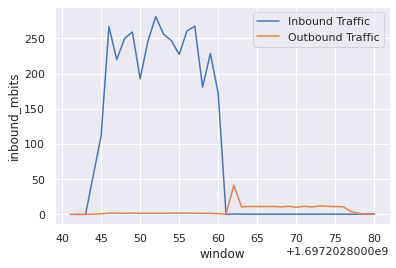

In [6]:
# Top inbound server IPs from Task 4
top_inbound_ips = inbound_flow_stats.head(5).index.get_level_values('src')

# Top outbound server IPs from Task 4
top_outbound_ips = outbound_flow_stats.head(5).index.get_level_values('dst')

# Filter for relevant inbound traffic
inbound_df = df[(df['dst'] == '192.168.0.203') & (df['src'].isin(top_inbound_ips))]

# Filter for relevant outbound traffic
outbound_df = df[(df['src'] == '192.168.0.203') & (df['dst'].isin(top_outbound_ips))]

# Round the time to nearest second to group per second
inbound_df['window'] = inbound_df['time'].astype(int)
outbound_df['window'] = outbound_df['time'].astype(int)

# For inbound traffic: Group by time and sum bytes
inbound_bytes_per_sec = (
    inbound_df.groupby('window')['len']
    .sum()
    .reset_index()
    .rename(columns={'len': 'inbound_bytes'})
)

# For outbound traffic: Group by time and sum bytes
outbound_bytes_per_sec = (
    outbound_df.groupby('window')['len']
    .sum()
    .reset_index()
    .rename(columns={'len': 'outbound_bytes'})
)

# Convert bytes to megabits
inbound_bytes_per_sec['inbound_mbits'] = inbound_bytes_per_sec['inbound_bytes'] * 8 / 1e6
outbound_bytes_per_sec['outbound_mbits'] = outbound_bytes_per_sec['outbound_bytes'] * 8 / 1e6

# Plot inbound traffic
sns.lineplot(x='window', y='inbound_mbits', data=inbound_bytes_per_sec, label='Inbound Traffic')

# Plot outbound traffic
sns.lineplot(x='window', y='outbound_mbits', data=outbound_bytes_per_sec, label='Outbound Traffic')


### Task 6
Identify the flows that are relevant to the speed test. (Hint: The number of packets sent in each flow and the protocol are useful indicators for which servers are used for the speed test)

In [7]:
# Group by protocol, source IP, destination IP, source port, and destination port
# Aggregate by summing the 'len' column to get total bytes per flow
likely_inbound_flows = (inbound_traffic.groupby(['proto', 'src', 'dst', 'sport', 'dport'], dropna=False)
    .agg(total_bytes=('len', 'sum'), packet_count=('len', 'size'))  # Sum bytes and count packets
    .sort_values(by='packet_count', ascending=False)                # Sort by packet count
    .reset_index())

# Display top flows by total bytes
likely_inbound_flows.head(10)  

,proto,src,dst,sport,dport,total_bytes,packet_count
0,6,172.102.123.3,192.168.0.203,8080.0,54304.0,46831987,31229
1,6,172.102.123.3,192.168.0.203,8080.0,54322.0,44431262,29632
2,6,172.102.123.3,192.168.0.203,8080.0,54320.0,30593167,20406
3,6,172.102.123.3,192.168.0.203,8080.0,54324.0,29257220,19513
4,6,172.102.123.3,192.168.0.203,8080.0,54321.0,26684762,17801
5,6,45.61.24.162,192.168.0.203,8080.0,54314.0,22517666,15019
6,6,45.61.24.162,192.168.0.203,8080.0,54302.0,22455253,14977
7,6,172.102.123.3,192.168.0.203,8080.0,54323.0,22314504,14882
8,6,45.61.24.162,192.168.0.203,8080.0,54311.0,20752872,13845
9,6,184.182.243.145,192.168.0.203,8080.0,54301.0,18436313,12296


In [8]:
# Group by protocol, source IP, destination IP, source port, and destination port
# Aggregate by summing the 'len' column to get total bytes per flow
likely_outbound_flows = (outbound_traffic.groupby(['proto', 'src', 'dst', 'sport', 'dport'], dropna=False)
    .agg(total_bytes=('len', 'sum'), packet_count=('len', 'size'))  # Sum bytes and count packets
    .sort_values(by='packet_count', ascending=False)                # Sort by packet count
    .reset_index())

# Display top flows by total bytes
likely_outbound_flows.head(10)  


,proto,src,dst,sport,dport,total_bytes,packet_count
0,6,192.168.0.203,184.182.243.145,54330.0,8080.0,9947080,6647
1,6,192.168.0.203,172.102.123.3,54324.0,8080.0,216892,3940
2,6,192.168.0.203,172.102.123.3,54304.0,8080.0,215307,3759
3,6,192.168.0.203,172.102.123.3,54321.0,8080.0,198717,3567
4,6,192.168.0.203,184.182.243.145,54329.0,8080.0,5292173,3544
5,6,192.168.0.203,172.102.123.3,54320.0,8080.0,191363,3447
6,6,192.168.0.203,184.182.243.145,54332.0,8080.0,5147940,3443
7,6,192.168.0.203,172.102.123.3,54322.0,8080.0,188873,3422
8,6,192.168.0.203,184.182.243.145,54306.0,8080.0,167077,3139
9,6,192.168.0.203,184.182.243.145,54331.0,8080.0,4610831,3089


### Task 7
Estimate the duration of the upload and download portions of the speed test using the flows identified in the previous task. Group the packets by their timestamps into 1-second windows and calculate the number of packets per second for each window. Focus on full-sized packets (length = 1500 bytes) transmitted between the client and the server. The speed test is considered active in windows where approximately 1000 or more full-sized packets are observed per second. The duration of the test is defined by the time between the first and last window across all flows that meet this condition. Report the minimum time (start of the first active window), the maximum time (end of the last active window), and the overall duration (difference between the maximum and minimum times).

In [9]:
# Extract unique IPs for inbound and outbound flows
inbound_src_ips = likely_inbound_flows['src'].unique()  # Unique source IPs for inbound traffic (download)
outbound_dst_ips = likely_outbound_flows['dst'].unique()  # Unique destination IPs for outbound traffic (upload)


# Filter original df based on these IPs

# Download (inbound) traffic: Filter where src is in inbound_src_ips and dst is the client IP
download_traffic = df[(df['src'].isin(inbound_src_ips)) & (df['dst'] == '192.168.0.203')]
# Upload (outbound) traffic: Filter where src is the client IP and dst is in outbound_dst_ips
upload_traffic = df[(df['src'] == '192.168.0.203') & (df['dst'].isin(outbound_dst_ips))]

# Filter for full-sized packets (1500 bytes)
download_traffic = download_traffic[download_traffic['len'] == 1500]
upload_traffic = upload_traffic[upload_traffic['len'] == 1500]

# Round the time to nearest second for 1-second windows
download_traffic['window'] = download_traffic['time'].astype(int)
upload_traffic['window'] = upload_traffic['time'].astype(int)

# Aggregate for download and upload traffic: sum bytes and count packets per window
download_stats = (
    download_traffic.groupby('window', dropna=False)
                   .agg(bytes=('len', 'sum'), packet_count=('time', 'count'))
                   .sort_values('window', ascending=True)
)

upload_stats = (
    upload_traffic.groupby('window', dropna=False)
                 .agg(bytes=('len', 'sum'), packet_count=('time', 'count'))
                 .sort_values('window', ascending=True)
)

# Filter for active windows
# 1000 packets/sec for download and 800 packets/sec for upload
active_download_windows = download_stats[download_stats['packet_count'] >= 1000]
active_upload_windows = upload_stats[upload_stats['packet_count'] >= 800]

# Calculate start time, end time, and duration for download and upload
if not active_download_windows.empty:
    download_start_time = active_download_windows.index.min()
    download_end_time = active_download_windows.index.max()
    download_duration = download_end_time - download_start_time
    print(f"Download - Start Time: {download_start_time}, End Time: {download_end_time}, Duration: {download_duration} seconds")
else:
    print("No active download windows found.")

if not active_upload_windows.empty:
    upload_start_time = active_upload_windows.index.min()
    upload_end_time = active_upload_windows.index.max()
    upload_duration = upload_end_time - upload_start_time
    print(f"Upload - Start Time: {upload_start_time}, End Time: {upload_end_time}, Duration: {upload_duration} seconds")
else:
    print("No active upload windows found.")


Download - Start Time: 1697202845, End Time: 1697202860, Duration: 15 seconds
Upload - Start Time: 1697202862, End Time: 1697202876, Duration: 14 seconds


### Task 8
For this task, you wil use a new windowing approach over all flows you identified relevant to the speed test for download and upload. Split the duration of the test into 20 windows, and aggregate the bytes over all relevant flows for each window. Report the total bytes measured over each of the 20 windows as well as the duration of each window for upload and download. (Hint: Use the `pd.cut` function to create a new column for this windowing approach)

In [10]:
# Define the 20 equal windows for download and upload based on Task 7's start and end times

# Download traffic windows
download_bins = np.linspace(download_start_time, download_end_time, 21)  # 20 windows
download_stats['download_window'] = pd.cut(download_stats.index, bins=download_bins, include_lowest=True)

# Upload traffic windows
upload_bins = np.linspace(upload_start_time, upload_end_time, 21)  # 20 windows
upload_stats['upload_window'] = pd.cut(upload_stats.index, bins=upload_bins, include_lowest=True)

# Aggregate bytes for each window
download_window_stats = (
    download_stats.groupby('download_window')['bytes']
    .sum()
    .reset_index()
    .rename(columns={'bytes': 'total_download_bytes'})
)

upload_window_stats = (
    upload_stats.groupby('upload_window')['bytes']
    .sum()
    .reset_index()
    .rename(columns={'bytes': 'total_upload_bytes'})
)

# Calculate window duration
download_window_duration = (download_end_time - download_start_time) / 20
upload_window_duration = (upload_end_time - upload_start_time) / 20

# Display the results
print("Download window stats:")
for idx, row in download_window_stats.iterrows():
    print(f"Window {idx + 1}: {int(row['total_download_bytes'])} bytes, Duration: {download_window_duration:.2f} seconds")

print("\nUpload window stats:")
for idx, row in upload_window_stats.iterrows():
    print(f"Window {idx + 1}: {int(row['total_upload_bytes'])} bytes, Duration: {upload_window_duration:.2f} seconds")


Download window stats:
Window 1: 13941000 bytes, Duration: 0.75 seconds
Window 2: 33289500 bytes, Duration: 0.75 seconds
Window 3: 27462000 bytes, Duration: 0.75 seconds
Window 4: 31204500 bytes, Duration: 0.75 seconds
Window 5: 0 bytes, Duration: 0.75 seconds
Window 6: 32377500 bytes, Duration: 0.75 seconds
Window 7: 24060000 bytes, Duration: 0.75 seconds
Window 8: 30799500 bytes, Duration: 0.75 seconds
Window 9: 0 bytes, Duration: 0.75 seconds
Window 10: 35088000 bytes, Duration: 0.75 seconds
Window 11: 31996500 bytes, Duration: 0.75 seconds
Window 12: 30840000 bytes, Duration: 0.75 seconds
Window 13: 0 bytes, Duration: 0.75 seconds
Window 14: 28405500 bytes, Duration: 0.75 seconds
Window 15: 32560500 bytes, Duration: 0.75 seconds
Window 16: 33406500 bytes, Duration: 0.75 seconds
Window 17: 0 bytes, Duration: 0.75 seconds
Window 18: 22587000 bytes, Duration: 0.75 seconds
Window 19: 28557000 bytes, Duration: 0.75 seconds
Window 20: 21516000 bytes, Duration: 0.75 seconds

Upload window

### Task 9
Discard the windows with the 3 lowest and top 2 number of bytes. Estimate the download and upload throughput in Mbps from these 15 windows, where throughput is bytes divided by duration. (Hint: The duration of each window is equal to the duration of the speedtest divided by 20. Therefore the new duration to use for the throughput calcuation for the 15 windows is equal to 0.75 times the duration of the download / upload test you reported in Task 7.)

In [11]:
# Step 1: Sort and filter windows by total bytes

# Sort and filter download windows
sorted_download_windows = download_window_stats.sort_values(by='total_download_bytes')
filtered_download_windows = sorted_download_windows[3:-2]  # Remove 3 lowest and 2 highest

# Sort and filter upload windows
sorted_upload_windows = upload_window_stats.sort_values(by='total_upload_bytes')
filtered_upload_windows = sorted_upload_windows[3:-2]  # Remove 3 lowest and 2 highest

# Calculate total duration for the remaining 15 windows
adjusted_download_duration = download_duration * 0.75
adjusted_upload_duration = upload_duration * 0.75

# Calculate total bytes for the remaining 15 windows
total_download_bytes = filtered_download_windows['total_download_bytes'].sum()
total_upload_bytes = filtered_upload_windows['total_upload_bytes'].sum()

# Calculate throughput in Mbps
download_throughput_mbps = (total_download_bytes * 8) / (adjusted_download_duration * 1e6)
upload_throughput_mbps = (total_upload_bytes * 8) / (adjusted_upload_duration * 1e6)

# Display results
print(f"Estimated Download Throughput: {download_throughput_mbps:.2f} Mbps")
print(f"Estimated Upload Throughput: {upload_throughput_mbps:.2f} Mbps")


Estimated Download Throughput: 277.05 Mbps
Estimated Upload Throughput: 13.53 Mbps
